In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/QROT/notebooks/ex_gaussian`


In [2]:
using OptimalTransport
using Plots
using LinearAlgebra
using Distributions
using Random
using NearestNeighbors
using SparseArrays
using MultivariateStats
using SimpleWeightedGraphs
using GraphPlot
using PyCall
using Clustering
using Glob
using Serialization
using StatsPlots
using LaTeXStrings
using ProgressMeter
using CSV
using DataFrames
using StatsBase
using ColorSchemes

include("../../src/util.jl")
Random.seed!(0)

[ Info: Precompiling MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411]
[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]


TaskLocalRNG()

In [3]:
pal=palette(:Set1_9)

plt1s = []
plt2s = []

N = 500
# d = 50

# for N in [100, 250, 500]
for d in [10, 50, 250]
    fnames = Glob.glob("output/gaussian_results_N_$(N)_d_$(d)_seed_*.csv")
    print(fnames)

    df = [CSV.read(f, DataFrame) for f in fnames];
    plt=plot(; ylim = (0.575, 1.0), size = (500, 250), title = latexstring("\$d\$ = $d"), titlefontsize = 10)
    errorline!(df[1].eps_quad, hcat([x.nmi_quad for x in df]...), xscale = :log10, marker = :circle, label = "QOT", legend = :outertopright, color = pal[2], groupcolor = pal[2], xlabel = L"\varepsilon", ylabel = "NMI", markerstrokewidth = 0)
    errorline!(df[1].eps_ent, hcat([x.nmi_ent for x in df]...), xscale = :log10, marker = :circle, label = "EOT", color = pal[1], groupcolor = pal[1], markerstrokewidth = 0)
    errorline!(df[1].eps_quad, hcat([x.nmi_quad_fat for x in df]...), xscale = :log10, marker = :circle, label = "QOT (fat)", color = pal[3], groupcolor = pal[3], markerstrokewidth = 0)
    errorline!(df[1].eps_ent, hcat([x.nmi_ent_fat for x in df]...), xscale = :log10, marker = :circle, label = "EOT (fat)", color = pal[4], groupcolor = pal[4], markerstrokewidth = 0)
    z = mean([maximum(x.nmi_knn) for x in df])
    if z < 0.575
        annotate!(25, 0.65, (latexstring("↓ \$k\$-NN: $(round(z, digits = 2))"), 8, pal[5]))
    else
        hline!([z, ], label = L"$k$-NN (best over all $k$)", color = pal[5], linestyle = :dash)
    end
    push!(plt1s, plt)

    plt=plot(; ylim = (0.1, 1.1), size = (500, 250), title = latexstring("\$d\$ = $d"), titlefontsize = 10, yscale = :log10)
    errorline!(df[1].eps_quad, hcat([x.theta_quad for x in df]...), xscale = :log10, marker = :circle, label = "QOT", legend = :outertopright, color = pal[2], groupcolor = pal[2], xlabel = L"\varepsilon", ylabel = L"\langle\theta\rangle", markerstrokewidth = 0)
    errorline!(df[1].eps_ent, hcat([x.theta_ent for x in df]...), xscale = :log10, marker = :circle, label = "EOT", color = pal[1], groupcolor = pal[1], markerstrokewidth = 0)
    errorline!(df[1].eps_quad, hcat([x.theta_quad_fat for x in df]...), xscale = :log10, marker = :circle, label = "QOT (fat)", color = pal[3], groupcolor = pal[3], markerstrokewidth = 0)
    errorline!(df[1].eps_ent, hcat([x.theta_ent_fat for x in df]...), xscale = :log10, marker = :circle, label = "EOT (fat)", color = pal[4], groupcolor = pal[4], markerstrokewidth = 0)
    hline!([mean([minimum(x.theta_knn) for x in df]), ], label = L"$k$-NN (best over all $k$)", color = pal[5], linestyle = :dash)
    push!(plt2s, plt)
end

["output/gaussian_results_N_500_d_10_seed_1.csv", "output/gaussian_results_N_500_d_10_seed_10.csv", "output/gaussian_results_N_500_d_10_seed_2.csv", "output/gaussian_results_N_500_d_10_seed_3.csv", "output/gaussian_results_N_500_d_10_seed_4.csv", "output/gaussian_results_N_500_d_10_seed_5.csv", "output/gaussian_results_N_500_d_10_seed_6.csv", "output/gaussian_results_N_500_d_10_seed_7.csv", "output/gaussian_results_N_500_d_10_seed_8.csv", "output/gaussian_results_N_500_d_10_seed_9.csv"]["output/gaussian_results_N_500_d_50_seed_1.csv", "output/gaussian_results_N_500_d_50_seed_10.csv", "output/gaussian_results_N_500_d_50_seed_2.csv", "output/gaussian_results_N_500_d_50_seed_3.csv", "output/gaussian_results_N_500_d_50_seed_4.csv", "output/gaussian_results_N_500_d_50_seed_5.csv", "output/gaussian_results_N_500_d_50_seed_6.csv", "output/gaussian_results_N_500_d_50_seed_7.csv", "output/gaussian_results_N_500_d_50_seed_8.csv", "output/gaussian_results_N_500_d_50_seed_9.csv"]["output/gaussian_

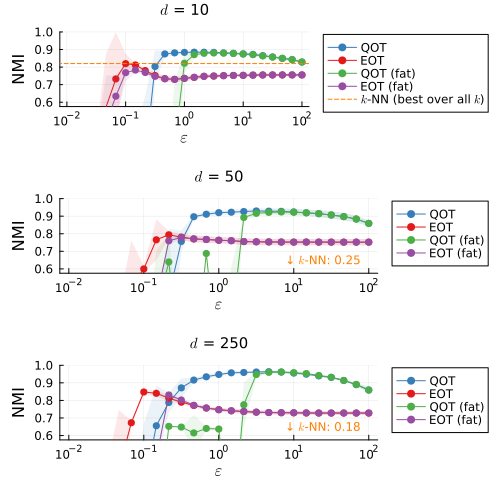

In [4]:
plt=plot(plt1s...; layout = (3, 1), size = (500, 500))
savefig(plt, "../../figures/gaussian_NMI_vs_eps.svg")
plt

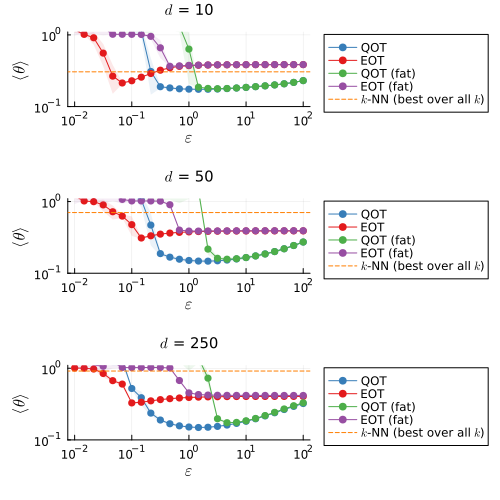

In [5]:
plt=plot(plt2s...; layout = (3, 1), size = (500, 500))
savefig(plt, "../../figures/gaussian_theta_vs_eps.svg")
plt

In [6]:
using NPZ
N = 500
d = 50
X = npzread("output/X_N_$(N)_d_$(d)_seed_1.npy")
y = npzread("output/y_N_$(N)_d_$(d)_seed_1.npy");

In [7]:
using LogExpFunctions
eps_quad = 1.0 # 2.5
K_quad_, u_quad_ = kernel_ot_quad(X, eps_quad, potentials = true);
perplexity(K) = map(x -> exp(sum(-xlogx.(x))), eachrow(K))
perp_quad = mean(perplexity(K_quad_))

29.599628783339636

In [8]:
# simple bisection search to match perplexity
eps_ent_l, eps_ent_r = 0.0, 0.1
K_ent_, u_ent_ = similar(K_quad_), similar(u_quad_)
for _ = 1:10
    eps_ent = (eps_ent_l + eps_ent_r)/2
    K_ent_, u_ent_ = kernel_ot_ent(X, eps_ent, potentials = true)
    u_ent_ = log.(u_ent_)
    perp_ent = mean(perplexity(K_ent_))
    if perp_ent > perp_quad 
        eps_ent_r = eps_ent
    else
        eps_ent_l = eps_ent
    end
    @info "perp_ent = $(perp_ent), eps_ent = $(eps_ent)"
end

[ Info: perp_ent = 254.97092356152103, eps_ent = 0.05
[ Info: perp_ent = 119.74612240408067, eps_ent = 0.025
┌ Warning: Symmetric Sinkhorn algorithm (5000/5000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/p1fRd/src/entropic/sinkhorn_solve.jl:103
[ Info: perp_ent = 38.7550480183164, eps_ent = 0.0125
┌ Warning: Symmetric Sinkhorn algorithm (5000/5000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/p1fRd/src/entropic/sinkhorn_solve.jl:103
[ Info: perp_ent = 7.086440027142887, eps_ent = 0.00625
┌ Warning: Symmetric Sinkhorn algorithm (5000/5000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/p1fRd/src/entropic/sinkhorn_solve.jl:103
[ Info: perp_ent = 19.05811415794188, eps_ent = 0.009375000000000001
┌ Warning: Symmetric Sinkhorn algorithm (5000/5000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/p1fRd/src/entropic/sinkhorn_solve.jl:103
[ Info: perp_ent = 28.19737833349989, eps_ent = 0.010937

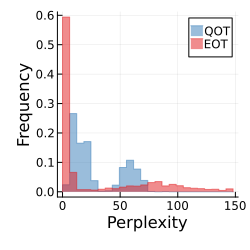

In [9]:
plt=stephist(perplexity(K_quad_), weights = ones(size(K_quad_, 1))/size(K_quad_, 1), alpha = 0.5, bins = range(0, 5*perp_quad, 25), label = "QOT", fill = true, xlabel = "Perplexity", ylabel = "Frequency", size = (250, 250), color = pal[2])
stephist!(perplexity(K_ent_), weights = ones(size(K_ent_, 1))/size(K_ent_, 1), alpha = 0.5, bins = range(0, 5*perp_quad, 25), label = "EOT", fill = true, color = pal[1])
savefig(plt, "../../figures/gaussian_perplexity_freq_d_$(d).svg")
plt

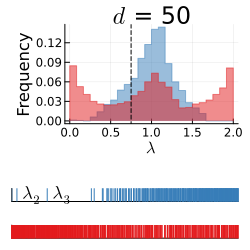

In [10]:
using LaTeXStrings

eigs_quad = eigen(I - Hermitian(symm(K_quad_)));
eigs_ent = eigen(I - Hermitian(symm(K_ent_)));

t = 0.75
plt=stephist(eigs_quad.values, weights = ones(size(K_quad_, 1))/size(K_quad_, 1), bins = range(0, 2, 25), fill = true, color = pal[2], alpha = 0.5, size = (250, 250), label = "Bistochastic L2")
stephist!(eigs_ent.values, weights = ones(size(K_ent_, 1))/size(K_ent_, 1), bins = range(0, 2, 25), fill = true, color = pal[1], alpha = 0.5, label = "Bistochastic Ent", legend = nothing, xlabel = L"$\lambda$", ylabel = "Frequency")
vline!([t, ], linestyle = :dash, color = :black)
# savefig(plt, "../../figures/gaussian_eigenvalues.svg")
# plt
plt1=vline(eigs_quad.values, xlim = (0, t), axis = nothing, color = pal[2], alpha = 1, legend = nothing, linewidth = 1)
annotate!(plt1, eigs_quad.values[2] + 0.05, 1.5, (L"$λ_2$", 12))
annotate!(plt1, eigs_quad.values[3] + 0.05, 1.5, (L"$λ_3$", 12))
plt2=vline(eigs_ent.values, xlim = (0, t), axis = nothing, color = pal[1], alpha = 1, legend = nothing, linewidth = 1)
_plt=plot(plt1, plt2; layout = (2, 1), size = (250, 100));
# savefig(_plt, "../../figures/gaussian_eigenvalues_zoom.svg")
# _plt

__plt = plot(plt, _plt; layout = StatsPlots.grid(2, 1, heights=[2/3, 1/3]), plot_title = latexstring("\$d\$ = $d"))
savefig(__plt, "../../figures/gaussian_eigenvalues_d_$(d).pdf")
__plt

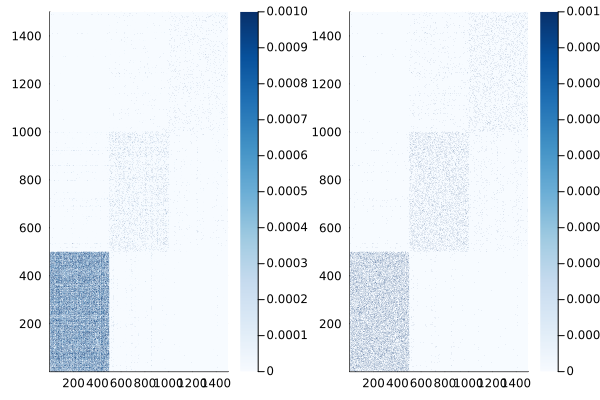

In [11]:
plot(heatmap(K_ent_; colormap = :Blues, clim = (0, 0.001)), heatmap(K_quad_; colormap = :Blues, clim = (0, 0.001)))

In [12]:
k = Int(round(perp_quad; digits = 0))
K_knn_ = Array(norm_kernel(symm(knn_adj(X, k)), :sym));

In [13]:
X_pca = predict(fit(PCA, X; maxoutdim = 2), X);

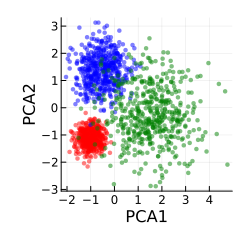

In [14]:
colordict = Dict(0 => colorant"red", 1 => colorant"blue", 2 => colorant"green")
plt=scatter(X_pca[1, :], X_pca[2, :], markerstrokewidth = 0, alpha = 0.5, color = [colordict[x-1] for x in y], markersize = 2.5, legend = nothing, xlabel = "PCA1", ylabel = "PCA2", size = (250, 250), margin = 2.5*Plots.mm)
savefig("../../figures/gaussian_true_clusters.svg")
plt

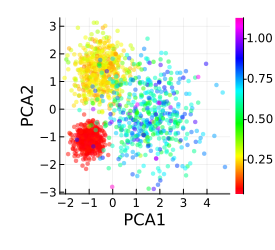

In [15]:
plt=scatter(X_pca[1, :], X_pca[2, :], markerstrokewidth = 0, alpha = 0.5, marker_z = u_quad_, markersize = 2.5, legend = nothing, xlabel = "PCA1", ylabel = "PCA2", size = (275, 250), color = :gist_rainbow, colorbar = true, margin = 2.5*Plots.mm)
savefig("../../figures/gaussian_dual_potentials.svg")
plt

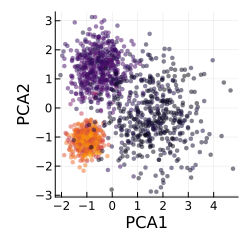

In [16]:
scatter(X_pca[1, :], X_pca[2, :], markerstrokewidth = 0, alpha = 0.5, marker_z = perplexity(K_quad_), markersize = 2.5, legend = nothing, xlabel = "PCA1", ylabel = "PCA2", size = (250, 250))

In [17]:
import Cairo, Fontconfig
using Graphs
using Compose
K_thresh = copy(symm(K_ent_))
thresh = quantile(vec(K_thresh), 0)
K_thresh[K_thresh .< thresh] .= 0
g = SimpleWeightedGraph(K_thresh)
nodefillc = [colordict[x-1] for x in y]
plt=gplot(g, X_pca[1, :], X_pca[2, :], nodefillc = nodefillc, 
    nodestrokec = [colorant"black" for _ in nodefillc], nodestrokelw = [0 for _ in nodefillc], 
    edgestrokec = RGBA(0.1, 0.1, 0.1, 1), edgelinewidth = [e.weight for e in edges(g)], EDGELINEWIDTH = 0.5
    )
draw(PNG("../../figures/gmm_ent.png", 16cm, 16cm, dpi = 300), plt)

In [18]:
K_thresh = copy(symm(K_quad_))
thresh = quantile(vec(K_thresh), 0)
K_thresh[K_thresh .< thresh] .= 0
g = SimpleWeightedGraph(K_thresh)
nodefillc = [colordict[x-1] for x in y]
plt=gplot(g, X_pca[1, :], X_pca[2, :], nodefillc = nodefillc, 
    nodestrokec = [colorant"black" for _ in nodefillc], nodestrokelw = [0 for _ in nodefillc], 
    edgestrokec = RGBA(0.1, 0.1, 0.1, 1), edgelinewidth = [e.weight for e in edges(g)], EDGELINEWIDTH = 0.5
    )
draw(PNG("../../figures/gmm_quad.png", 16cm, 16cm, dpi = 300), plt)

In [19]:
K_thresh = copy(symm(K_knn_))
thresh = quantile(vec(K_thresh), 0)
K_thresh[K_thresh .< thresh] .= 0
g = SimpleWeightedGraph(K_thresh)
nodefillc = [colordict[x-1] for x in y]
plt=gplot(g, X_pca[1, :], X_pca[2, :], nodefillc = nodefillc, 
    nodestrokec = [colorant"black" for _ in nodefillc], nodestrokelw = [0 for _ in nodefillc], 
    edgestrokec = RGBA(0.1, 0.1, 0.1, 1), edgelinewidth = [e.weight for e in edges(g)], EDGELINEWIDTH = 0.5
    )
draw(PNG("../../figures/gmm_knn.png", 16cm, 16cm, dpi = 300), plt)

In [20]:
# plts_all = []
# for (w, t) in zip([K_quad_, K_ent_, K_knn_], ["Bistochastic L2", "Bistochastic entropic", "kNN + Gaussian"])
#     v = eigen(Hermitian(I - w)).vectors[:, 2]
#     lim =quantile(abs.(v), 0.9)
#     push!(plts_all, scatter(X_pca[1, :], -X_pca[2, :], marker_z = v, 
#                     color = :RdBu, markerstrokewidth = 0, legend = nothing, title = t, colorbar = true, alpha = 0.5, clim = (-lim, lim), axis = nothing))
# end
# plt=plot(plts_all...; layout = (1, 3), size = (1000, 250))
# savefig("../figures/gmm_fiedler_vector.pdf")
# plt

In [21]:
eigs_quad = eigen(I - Hermitian(symm(K_quad_)));
eigs_ent = eigen(I - Hermitian(symm(K_ent_)));

In [22]:
plt1=plot([scatter(X_pca[1, :], X_pca[2, :], marker_z = eigs_ent.vectors[:, i], colormap = :RdBu, clim = (-0.05, 0.05), alpha = 0.5, title = latexstring("\$\\mathbf{v}_{$(i)}\$"), rasterized = true) for i = 2:5]...; 
    layout = (1, 4), colorbar = false, markerstrokewidth = 0.5, legend = nothing)
plt2=plot([scatter(X_pca[1, :], X_pca[2, :], marker_z = eigs_quad.vectors[:, i], colormap = :RdBu, clim = (-0.05, 0.05), alpha = 0.5, title = latexstring("\$\\mathbf{v}_{$(i)}\$")) for i = 2:5]...; 
    layout = (1, 4), colorbar = false, markerstrokewidth = 0.5, legend = nothing)
plt=plot(plt2, plt1; layout = (2, 1), size = (750, 375), xlabel = "PCA1", ylabel = "PCA2", xlabelfontsize = 8, ylabelfontsize = 8)
savefig(plt, "../../figures/gaussian_eigenvectors.svg")
plt

In [23]:
using Interpolations # from https://github.com/JuliaPlots/Plots.jl/issues/2857
function Interp2D(data, factor)
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)
    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)
    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end
    return finerx, finery, data_interp
end

Interp2D (generic function with 1 method)

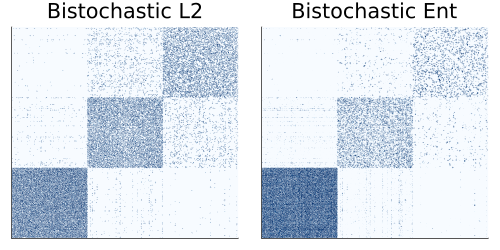

In [24]:
plt=plot(heatmap(Interp2D(K_quad_, 3), clim = (0, 3e-4), title = "Bistochastic L2", colormap = :Blues),
         heatmap(Interp2D(K_ent_, 3), clim = (0, 3e-4), title = "Bistochastic Ent", colormap = :Blues),
    colorbar = false, size = (500, 250), xaxis = nothing, yaxis = nothing)
savefig(plt, "../../figures/gaussian_heatmap.svg")
plt

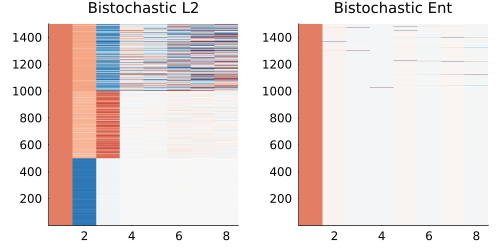

In [25]:
function get_diffusion_embeddings(eigs, τ)
    (abs.(1 .- eigs.values).^τ .* eigs.vectors')'
end

U_quad = get_diffusion_embeddings(eigs_quad, 1.)
U_ent = get_diffusion_embeddings(eigs_ent, 1.)
plot(heatmap(U_quad[:, 1:8], cmap = :RdBu, title = "Bistochastic L2", titlefontsize = 10), 
    heatmap(U_ent[:, 1:8], cmap = :RdBu, title = "Bistochastic Ent", titlefontsize = 10), clim = (-0.05, 0.05), colorbar = nothing, size = (500, 250))

In [26]:
# Test against number of PCA components
N = 500
d = 250
fnames = Glob.glob("output/gaussian_results_N_$(N)_d_$(d)_seed_*.csv")
df = [CSV.read(f, DataFrame) for f in fnames];

eps_quad_idx = argmax(mean([x.nmi_quad for x in df]))
eps_ent_idx = argmax(mean([x.nmi_ent for x in df]))
k_idx = argmax(mean([x.nmi_knn for x in df]))
eps_quad_idx, eps_ent_idx, k_idx

(17, 7, 23)

In [27]:
nmis_quad, nmis_ent, nmis_knn = [], [], []
thetas_quad, thetas_ent, thetas_knn = [], [], []
ns_pcas = []
for i = 1:10
    fnames = Glob.glob("output/gaussian_results_pca_*_N_$(N)_d_$(d)_seed_$(i).csv")
    n_pcas = [parse(Int, split(x, "_")[4]) for x in fnames]
    res = [CSV.read(f, DataFrame) for f in fnames]
    nmi_quad, nmi_ent, nmi_knn, theta_quad, theta_ent, theta_knn = zip(map(x -> (x.nmi_quad[1], x.nmi_ent[1], x.nmi_knn[1], x.theta_quad[1], x.theta_ent[1], x.theta_knn[1]), res)...);
    push!(nmis_quad, collect(nmi_quad)[sortperm(n_pcas)])
    push!(nmis_ent, collect(nmi_ent)[sortperm(n_pcas)])
    push!(nmis_knn, collect(nmi_knn)[sortperm(n_pcas)])
    push!(thetas_quad, collect(theta_quad)[sortperm(n_pcas)])
    push!(thetas_ent, collect(theta_ent)[sortperm(n_pcas)])
    push!(thetas_knn, collect(theta_knn)[sortperm(n_pcas)])
    push!(ns_pcas, sort(n_pcas))
end

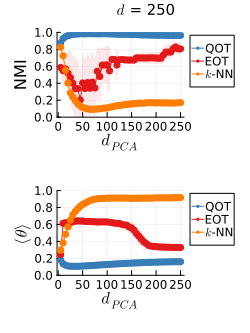

In [28]:
plt1=errorline(ns_pcas[1], hcat(nmis_quad...), marker = :circle, label = "QOT", legend = :outertopright, color = pal[2], groupcolor = pal[2], xlabel = L"$d_{PCA}$", ylabel = "NMI", markerstrokewidth = 0, size = (250, 250), ylim = (0, 1))
errorline!(ns_pcas[1], hcat(nmis_ent...); color = pal[1], groupcolor = pal[1], marker = :circle, markerstrokewidth = 0, label = "EOT")
errorline!(ns_pcas[1], hcat(nmis_knn...); color = pal[5], groupcolor = pal[5], marker = :circle, markerstrokewidth = 0, label = L"$k$-NN")
plt2=errorline(ns_pcas[1], hcat(thetas_quad...), marker = :circle, label = "QOT", legend = :outertopright, color = pal[2], groupcolor = pal[2], xlabel = L"$d_{PCA}$", ylabel = L"$\langle \theta \rangle$", markerstrokewidth = 0, size = (250, 250), ylim = (0, 1))
errorline!(ns_pcas[1], hcat(thetas_ent...); color = pal[1], groupcolor = pal[1], marker = :circle, markerstrokewidth = 0, label = "EOT")
errorline!(ns_pcas[1], hcat(thetas_knn...); color = pal[5], groupcolor = pal[5], marker = :circle, markerstrokewidth = 0, label = L"$k$-NN")
plt=plot(plt1, plt2; layout = (2, 1), size = (250, (2/3)*500), margin = 2*Plots.mm, plot_title = latexstring("\$d\$ = $(d)"), plot_titlefontsize = 10)
savefig(plt, "../../figures/gaussian_pca_nmi_theta.svg")
plt